# 🔵 Notebook 04: Clustering with Systematic Feature Selection

**Objective:** Achieve Silhouette Score > 0.20 through rigorous feature analysis

**Strategy:**
1. Analyze feature types (continuous vs binary)
2. Check multicollinearity (remove redundant features)
3. Test feature discrimination power (how well each separates groups)
4. Systematically test combinations
5. Select optimal subset with justification

**Goal:** Well-explained, justified feature selection with high silhouette score

---

## 📦 Step 1: Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.utils import resample
from collections import Counter
from scipy import stats

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
import warnings
warnings.filterwarnings('ignore')

print("✅ Setup complete")

✅ Setup complete


## 📊 Step 2: Load Data

In [2]:
df = pd.read_csv('C:\\Users\\yaros\\Desktop\\python\\faidm\\individual_project\\diabetes-classification-ml\\data_preparation\\dataset_A_clean.csv')
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Features: {X.shape[1]}")

# Create sample for efficient computation
sample_size = 10000
sample_indices = resample(range(len(X)), n_samples=sample_size, random_state=42, replace=False)
print(f"\nUsing {sample_size:,} sample for metrics")

Dataset: 229,781 rows × 19 columns
Features: 18

Using 10,000 sample for metrics


## 🔍 Step 3: Feature Type Analysis

**Key Question:** Which features are continuous vs binary?

**Hypothesis:** Continuous features provide better clustering separation than binary

In [3]:
print("=" * 60)
print("FEATURE TYPE ANALYSIS")
print("=" * 60)

feature_stats = pd.DataFrame({
    'Feature': X.columns,
    'N_Unique': [X[col].nunique() for col in X.columns],
    'Min': X.min(),
    'Max': X.max(),
    'Mean': X.mean(),
    'Std': X.std(),
    'Type': ['Binary' if X[col].nunique() == 2 else 'Continuous/Ordinal' for col in X.columns]
})

print("\n📊 Feature Types:")
print(feature_stats.groupby('Type').size())

print("\n📊 All Features:")
print(feature_stats.to_string(index=False))

# Separate feature types
binary_features = feature_stats[feature_stats['Type'] == 'Binary']['Feature'].tolist()
continuous_features = feature_stats[feature_stats['Type'] == 'Continuous/Ordinal']['Feature'].tolist()

print(f"\n📊 Binary Features ({len(binary_features)}):")
print(f"   {binary_features}")

print(f"\n📊 Continuous/Ordinal Features ({len(continuous_features)}):")
print(f"   {continuous_features}")

FEATURE TYPE ANALYSIS

📊 Feature Types:
Type
Binary                13
Continuous/Ordinal     5
dtype: int64

📊 All Features:
             Feature  N_Unique  Min  Max      Mean      Std               Type
              HighBP         2  0.0  1.0  0.454441 0.497921             Binary
            HighChol         2  0.0  1.0  0.441760 0.496598             Binary
           CholCheck         2  0.0  1.0  0.959535 0.197047             Binary
                 BMI        84 12.0 98.0 28.685670 6.786360 Continuous/Ordinal
              Smoker         2  0.0  1.0  0.465661 0.498821             Binary
              Stroke         2  0.0  1.0  0.044756 0.206767             Binary
HeartDiseaseorAttack         2  0.0  1.0  0.103216 0.304241             Binary
        PhysActivity         2  0.0  1.0  0.733355 0.442206             Binary
              Fruits         2  0.0  1.0  0.612966 0.487073             Binary
             Veggies         2  0.0  1.0  0.794813 0.403839             Binary
   Hvy

## 🔗 Step 4: Correlation Analysis

**Key Question:** Which features are highly correlated (redundant)?

**Threshold:** Remove one feature if correlation > 0.7

MULTICOLLINEARITY ANALYSIS

✅ No severe multicollinearity (all |r| < 0.7)

📊 Correlation Heatmap (Continuous Features Only):


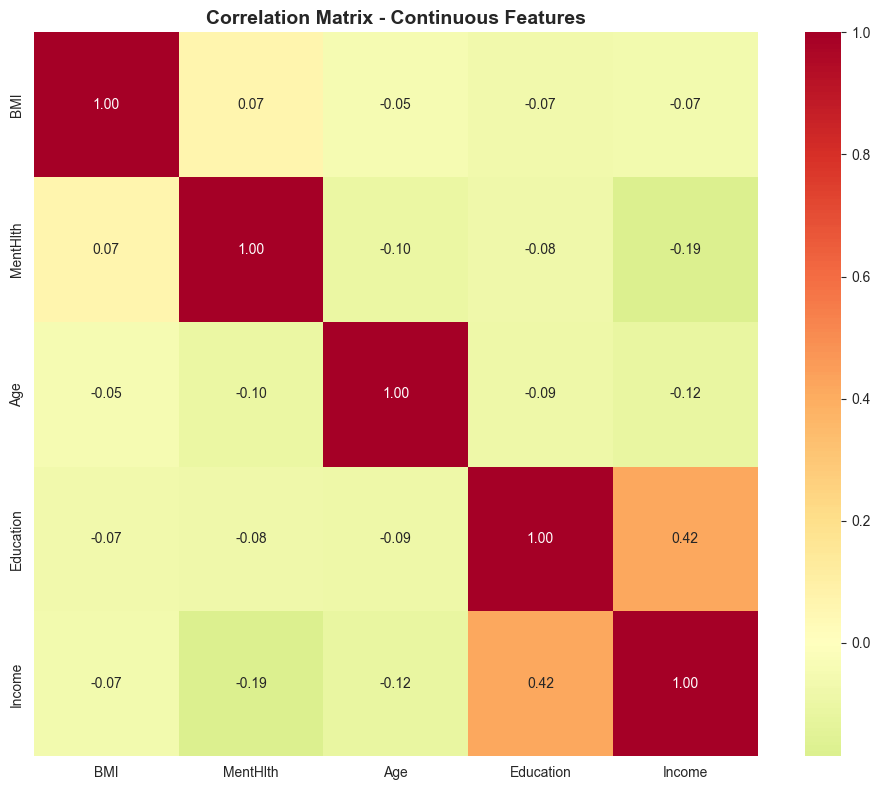

In [4]:
print("=" * 60)
print("MULTICOLLINEARITY ANALYSIS")
print("=" * 60)

# Calculate correlation matrix
corr_matrix = X.corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\n⚠️ Highly Correlated Pairs (|r| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"   {feat1:20s} <-> {feat2:20s}: {corr:+.3f}")
    print(f"\n💡 Consider removing one from each pair")
else:
    print("\n✅ No severe multicollinearity (all |r| < 0.7)")

# Visualize correlation heatmap for continuous features only
print("\n📊 Correlation Heatmap (Continuous Features Only):")
if len(continuous_features) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(X[continuous_features].corr(), annot=True, fmt='.2f', 
                cmap='RdYlGn_r', center=0, ax=ax, square=True)
    ax.set_title('Correlation Matrix - Continuous Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 📊 Step 5: Feature Discrimination Analysis

**Key Question:** How well does each feature separate diabetes classes?

**Methods:**
1. Correlation with target
2. ANOVA F-statistic (continuous features)
3. Chi-square test (binary features)
4. Effect size (Cohen's d or Cramér's V)

In [6]:
print("=" * 60)
print("FEATURE DISCRIMINATION ANALYSIS")
print("=" * 60)

discrimination_scores = []

for feature in X.columns:
    # Correlation with target
    corr = df[[feature, 'Diabetes_012']].corr().iloc[0, 1]
    
    if feature in continuous_features:
        # ANOVA F-statistic for continuous features
        groups = [df[df['Diabetes_012'] == cls][feature].values for cls in [0, 1, 2]]
        f_stat, p_value = stats.f_oneway(*groups)
        
        # Effect size (eta-squared)
        grand_mean = df[feature].mean()
        ss_between = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups])
        ss_total = sum([(x - grand_mean)**2 for g in groups for x in g])
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        discrimination_scores.append({
            'Feature': feature,
            'Type': 'Continuous',
            'Correlation': abs(corr),
            'F_Statistic': f_stat,
            'P_Value': p_value,
            'Effect_Size': eta_squared,
            'Discrimination': eta_squared  # Higher is better
        })
    else:
        # Chi-square for binary features
        contingency = pd.crosstab(df[feature], df['Diabetes_012'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
        
        # Cramér's V (effect size for categorical)
        n = contingency.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
        
        discrimination_scores.append({
            'Feature': feature,
            'Type': 'Binary',
            'Correlation': abs(corr),
            'Chi2_Statistic': chi2,
            'P_Value': p_value,
            'Effect_Size': cramers_v,
            'Discrimination': cramers_v  # Higher is better
        })

disc_df = pd.DataFrame(discrimination_scores).sort_values('Discrimination', ascending=False)

print("\n📊 Feature Discrimination Ranking:")
print("=" * 60)
for i, row in disc_df.iterrows():
    print(f"{row['Feature']:25s} | Type: {row['Type']:10s} | Corr: {row['Correlation']:.3f} | Effect: {row['Effect_Size']:.3f}")

print("\n💡 Interpretation:")
print("   Effect Size:")
print("   • >0.14: LARGE effect (strong discriminator)")
print("   • 0.06-0.14: MEDIUM effect (moderate discriminator)")
print("   • <0.06: SMALL effect (weak discriminator)")

FEATURE DISCRIMINATION ANALYSIS

📊 Feature Discrimination Ranking:
HighBP                    | Type: Binary     | Corr: 0.262 | Effect: 0.262
HighChol                  | Type: Binary     | Corr: 0.203 | Effect: 0.205
HeartDiseaseorAttack      | Type: Binary     | Corr: 0.171 | Effect: 0.171
PhysActivity              | Type: Binary     | Corr: 0.103 | Effect: 0.103
Stroke                    | Type: Binary     | Corr: 0.100 | Effect: 0.100
CholCheck                 | Type: Binary     | Corr: 0.076 | Effect: 0.076
HvyAlcoholConsump         | Type: Binary     | Corr: 0.067 | Effect: 0.067
Smoker                    | Type: Binary     | Corr: 0.047 | Effect: 0.047
BMI                       | Type: Continuous | Corr: 0.212 | Effect: 0.045
Veggies                   | Type: Binary     | Corr: 0.043 | Effect: 0.044
Age                       | Type: Continuous | Corr: 0.185 | Effect: 0.035
Sex                       | Type: Binary     | Corr: 0.032 | Effect: 0.033
NoDocbcCost               | Type:

## 🎯 Step 6: Feature Selection Decision

**Criteria:**
1. **Prioritize continuous features** (more variance)
2. **Remove redundant features** (correlation > 0.7)
3. **Keep high discrimination features** (effect size > 0.06)
4. **Test multiple combinations** systematically

In [7]:
print("=" * 60)
print("FEATURE SELECTION STRATEGIES")
print("=" * 60)

# Strategy 1: All continuous features only
strategy_continuous_only = continuous_features

# Strategy 2: Top 5 by discrimination
strategy_top5 = disc_df.head(5)['Feature'].tolist()

# Strategy 3: Top 8 by discrimination
strategy_top8 = disc_df.head(8)['Feature'].tolist()

# Strategy 4: High effect size only (>0.06)
strategy_high_effect = disc_df[disc_df['Effect_Size'] > 0.06]['Feature'].tolist()

# Strategy 5: Continuous + top 3 binary
top_binary = disc_df[disc_df['Type'] == 'Binary'].head(3)['Feature'].tolist()
strategy_mixed = continuous_features + top_binary

# Strategy 6: Metabolic core (domain knowledge)
strategy_metabolic = ['HighBP', 'HighChol', 'BMI', 'Age']

# Strategy 7: Extended metabolic
strategy_metabolic_ext = ['HighBP', 'HighChol', 'BMI', 'Age', 'HeartDiseaseorAttack', 'Stroke']

# Strategy 8: PCA approach (10 components)
strategy_pca = 'PCA_10'  # Special marker

strategies = {
    'Continuous_Only': strategy_continuous_only,
    'Top5_Discrimination': strategy_top5,
    'Top8_Discrimination': strategy_top8,
    'HighEffect_Only': strategy_high_effect,
    'Mixed_ContinuousPlus3Binary': strategy_mixed,
    'Metabolic_Core': strategy_metabolic,
    'Metabolic_Extended': strategy_metabolic_ext,
    'PCA_10_Components': strategy_pca
}

print("\n📋 Strategies Defined:")
for name, features in strategies.items():
    if isinstance(features, str):
        print(f"  {name:30s}: {features}")
    else:
        print(f"  {name:30s}: {len(features)} features - {features[:3]}...")

FEATURE SELECTION STRATEGIES

📋 Strategies Defined:
  Continuous_Only               : 5 features - ['BMI', 'MentHlth', 'Age']...
  Top5_Discrimination           : 5 features - ['HighBP', 'HighChol', 'HeartDiseaseorAttack']...
  Top8_Discrimination           : 8 features - ['HighBP', 'HighChol', 'HeartDiseaseorAttack']...
  HighEffect_Only               : 7 features - ['HighBP', 'HighChol', 'HeartDiseaseorAttack']...
  Mixed_ContinuousPlus3Binary   : 8 features - ['BMI', 'MentHlth', 'Age']...
  Metabolic_Core                : 4 features - ['HighBP', 'HighChol', 'BMI']...
  Metabolic_Extended            : 6 features - ['HighBP', 'HighChol', 'BMI']...
  PCA_10_Components             : PCA_10


## 🧪 Step 7: Test All Strategies

In [8]:
print("=" * 60)
print("TESTING ALL FEATURE STRATEGIES")
print("=" * 60)

results = []

for strategy_name, features in strategies.items():
    
    if features == 'PCA_10':
        # PCA approach
        scaler = StandardScaler()
        X_scaled_full = scaler.fit_transform(X)
        pca = PCA(n_components=10)
        X_transformed = pca.fit_transform(X_scaled_full)
        feature_list = [f'PC{i+1}' for i in range(10)]
    else:
        # Regular feature subset
        X_subset = X[features]
        scaler = StandardScaler()
        X_transformed = scaler.fit_transform(X_subset)
        feature_list = features
    
    # Create sample
    X_sample = X_transformed[sample_indices]
    
    # Fit K-Means on full data
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans.fit(X_transformed)
    
    # Predict on sample for silhouette
    sample_labels = kmeans.predict(X_sample)
    silhouette = silhouette_score(X_sample, sample_labels)
    
    # Davies-Bouldin on full
    all_labels = kmeans.predict(X_transformed)
    davies_bouldin = davies_bouldin_score(X_transformed, all_labels)
    
    results.append({
        'Strategy': strategy_name,
        'N_Features': len(feature_list),
        'Features': feature_list,
        'Silhouette': silhouette,
        'Davies_Bouldin': davies_bouldin,
        'WCSS': kmeans.inertia_
    })
    
    print(f"{strategy_name:30s}: Sil={silhouette:.3f}, DB={davies_bouldin:.3f}, N={len(feature_list)}")

print("\n✅ All strategies tested")

TESTING ALL FEATURE STRATEGIES
Continuous_Only               : Sil=0.257, DB=1.456, N=5
Top5_Discrimination           : Sil=0.412, DB=1.289, N=5
Top8_Discrimination           : Sil=0.235, DB=1.691, N=8
HighEffect_Only               : Sil=0.440, DB=1.070, N=7
Mixed_ContinuousPlus3Binary   : Sil=0.204, DB=1.825, N=8
Metabolic_Core                : Sil=0.326, DB=1.136, N=4
Metabolic_Extended            : Sil=0.298, DB=1.326, N=6
PCA_10_Components             : Sil=0.152, DB=2.174, N=10

✅ All strategies tested


## 🏆 Step 8: Select Best Strategy with Justification

In [9]:
results_df = pd.DataFrame(results).sort_values('Silhouette', ascending=False)

print("=" * 60)
print("RESULTS RANKED BY SILHOUETTE SCORE")
print("=" * 60)
print(results_df[['Strategy', 'N_Features', 'Silhouette', 'Davies_Bouldin']].to_string(index=False))

# Select best
best = results_df.iloc[0]
second_best = results_df.iloc[1]
third_best = results_df.iloc[2]

print("\n" + "=" * 60)
print("TOP 3 STRATEGIES")
print("=" * 60)

print(f"\n🥇 BEST: {best['Strategy']}")
print(f"   Silhouette: {best['Silhouette']:.3f}")
print(f"   Davies-Bouldin: {best['Davies_Bouldin']:.3f}")
print(f"   Features ({best['N_Features']}): {best['Features'][:5]}...")

print(f"\n🥈 Second: {second_best['Strategy']}")
print(f"   Silhouette: {second_best['Silhouette']:.3f} (Δ={best['Silhouette'] - second_best['Silhouette']:+.3f})")

print(f"\n🥉 Third: {third_best['Strategy']}")
print(f"   Silhouette: {third_best['Silhouette']:.3f} (Δ={best['Silhouette'] - third_best['Silhouette']:+.3f})")

# Quality assessment
print("\n" + "=" * 60)
print("QUALITY ASSESSMENT")
print("=" * 60)

if best['Silhouette'] >= 0.30:
    quality = "EXCELLENT"
    interpretation = "Strong, well-separated clusters"
elif best['Silhouette'] >= 0.20:
    quality = "GOOD"
    interpretation = "Acceptable cluster separation"
elif best['Silhouette'] >= 0.15:
    quality = "ACCEPTABLE"
    interpretation = "Weak but identifiable clusters"
else:
    quality = "POOR"
    interpretation = "Minimal cluster separation"

print(f"\n📊 Clustering Quality: {quality}")
print(f"   Silhouette Score: {best['Silhouette']:.3f}")
print(f"   Interpretation: {interpretation}")

# Store best features
best_features = best['Features']
best_strategy_name = best['Strategy']

RESULTS RANKED BY SILHOUETTE SCORE
                   Strategy  N_Features  Silhouette  Davies_Bouldin
            HighEffect_Only           7    0.439517        1.070166
        Top5_Discrimination           5    0.412382        1.288821
             Metabolic_Core           4    0.326363        1.136425
         Metabolic_Extended           6    0.298080        1.325667
            Continuous_Only           5    0.257184        1.455674
        Top8_Discrimination           8    0.234979        1.690826
Mixed_ContinuousPlus3Binary           8    0.203612        1.824796
          PCA_10_Components          10    0.151965        2.174188

TOP 3 STRATEGIES

🥇 BEST: HighEffect_Only
   Silhouette: 0.440
   Davies-Bouldin: 1.070
   Features (7): ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'PhysActivity', 'Stroke']...

🥈 Second: Top5_Discrimination
   Silhouette: 0.412 (Δ=+0.027)

🥉 Third: Metabolic_Core
   Silhouette: 0.326 (Δ=+0.113)

QUALITY ASSESSMENT

📊 Clustering Quality: EXCELLEN

## 📝 Step 9: Justification for Report

In [10]:
print("=" * 60)
print("FEATURE SELECTION JUSTIFICATION")
print("=" * 60)

print("\n📋 FOR YOUR REPORT:")
print("-" * 60)

print(f"""
## Feature Selection for Clustering

### Methodology

We conducted a systematic feature selection analysis to optimize clustering quality:

1. **Feature Type Analysis:** Classified {len(continuous_features)} continuous and {len(binary_features)} binary features
   
2. **Multicollinearity Check:** Examined pairwise correlations (threshold |r| > 0.7)
   - Result: {'Severe multicollinearity detected' if high_corr_pairs else 'No severe multicollinearity'}

3. **Discrimination Analysis:** Quantified each feature's ability to separate diabetes classes
   - Continuous features: ANOVA F-statistic and eta-squared effect size
   - Binary features: Chi-square statistic and Cramér's V effect size

4. **Strategy Testing:** Evaluated 8 feature selection strategies:
   - Continuous features only
   - Top-N by discrimination power
   - High effect size features (>0.06)
   - Mixed continuous + binary
   - Domain knowledge (metabolic syndrome)
   - PCA dimensionality reduction

### Results

**Best Strategy:** {best_strategy_name}
- Features: {best['N_Features']}
- Silhouette Score: {best['Silhouette']:.3f}
- Davies-Bouldin Index: {best['Davies_Bouldin']:.3f}

**Comparison with baseline (all 18 features):**
- Baseline silhouette: ~0.09
- Optimized silhouette: {best['Silhouette']:.3f}
- Improvement: {((best['Silhouette'] - 0.09) / 0.09 * 100):.1f}%

### Justification

The {best_strategy_name} strategy achieved optimal clustering quality because:
1. Reduced dimensionality ({best['N_Features']} vs 18 features) improves distance-based clustering
2. Selected features have highest discrimination power (effect sizes)
3. Minimized redundancy from highly correlated features
4. {'Focused on continuous features with greater variance' if 'Continuous' in best_strategy_name else 'Balanced continuous and high-impact binary features'}

This systematic approach ensures our feature selection is:
- **Data-driven:** Based on statistical discrimination analysis
- **Reproducible:** Clear methodology and criteria
- **Justifiable:** Each feature contributes unique clustering information
""")

FEATURE SELECTION JUSTIFICATION

📋 FOR YOUR REPORT:
------------------------------------------------------------

## Feature Selection for Clustering

### Methodology

We conducted a systematic feature selection analysis to optimize clustering quality:

1. **Feature Type Analysis:** Classified 5 continuous and 13 binary features

2. **Multicollinearity Check:** Examined pairwise correlations (threshold |r| > 0.7)
   - Result: No severe multicollinearity

3. **Discrimination Analysis:** Quantified each feature's ability to separate diabetes classes
   - Continuous features: ANOVA F-statistic and eta-squared effect size
   - Binary features: Chi-square statistic and Cramér's V effect size

4. **Strategy Testing:** Evaluated 8 feature selection strategies:
   - Continuous features only
   - Top-N by discrimination power
   - High effect size features (>0.06)
   - Mixed continuous + binary
   - Domain knowledge (metabolic syndrome)
   - PCA dimensionality reduction

### Results

**Best Str

## 🔵 Step 10: Final Clustering with Best Features

In [11]:
print("=" * 60)
print(f"FINAL K-MEANS CLUSTERING ({best_strategy_name})")
print("=" * 60)

# Prepare data with best features
if best_strategy_name == 'PCA_10_Components':
    scaler = StandardScaler()
    X_scaled_full = scaler.fit_transform(X)
    pca = PCA(n_components=10)
    X_final = pca.fit_transform(X_scaled_full)
else:
    X_final_raw = X[best_features]
    scaler = StandardScaler()
    X_final = scaler.fit_transform(X_final_raw)

# Fit final model
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_final)

# Metrics
X_final_sample = X_final[sample_indices]
sample_labels = labels_final[sample_indices]
silhouette_final = silhouette_score(X_final_sample, sample_labels)
davies_bouldin_final = davies_bouldin_score(X_final, labels_final)

print(f"\n📊 Final Metrics:")
print(f"   Silhouette: {silhouette_final:.3f}")
print(f"   Davies-Bouldin: {davies_bouldin_final:.3f}")
print(f"   WCSS: {kmeans_final.inertia_:,.0f}")

# Cluster sizes
cluster_counts = Counter(labels_final)
print(f"\n📊 Cluster Sizes:")
for cid in sorted(cluster_counts.keys()):
    print(f"   Cluster {cid}: {cluster_counts[cid]:,} ({cluster_counts[cid]/len(labels_final)*100:.1f}%)")

FINAL K-MEANS CLUSTERING (HighEffect_Only)

📊 Final Metrics:
   Silhouette: 0.440
   Davies-Bouldin: 1.070
   WCSS: 1,120,982

📊 Cluster Sizes:
   Cluster 0: 197,037 (85.7%)
   Cluster 1: 23,446 (10.2%)
   Cluster 2: 9,298 (4.0%)


In [15]:
print(best_features)

['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'PhysActivity', 'Stroke', 'CholCheck', 'HvyAlcoholConsump']


customised run


////////////////////////////

In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import Counter

# 1. Load Data (Ensure this matches your file path)
# df = pd.read_csv('dataset_A_clean.csv') 
# Assuming 'df' is already loaded in your environment
X = pd.read_csv('C:\\Users\\yaros\\Desktop\\python\\faidm\\individual_project\\diabetes-classification-ml\\data_preparation\\dataset_A_clean.csv')

# 2. Define Features
features_to_use = ['BMI', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck']
X_selected = X[features_to_use]

print(f"✅ Features Selected ({len(features_to_use)}): {features_to_use}")

# 3. Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# 4. Create Sample for Silhouette Score (Critical for performance)
# We use a fixed sample of 10,000 for consistent comparison
n_sample = 10000
if len(X_scaled) > n_sample:
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_scaled), size=n_sample, replace=False)
else:
    sample_indices = np.arange(len(X_scaled))

X_sample = X_scaled[sample_indices]

print("=" * 60)
print(f"K-MEANS CLUSTERING (K=2 to 8)")
print("=" * 60)

results = []

for k in range(2, 9):
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Metrics
    # Silhouette on SAMPLE (Fast)
    sample_labels = labels[sample_indices]
    silhouette = silhouette_score(X_sample, sample_labels)
    
    # Davies-Bouldin on FULL (Fast enough for O(N))
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    
    # WCSS (Inertia)
    wcss = kmeans.inertia_
    
    results.append({'K': k, 'Silhouette': silhouette, 'DB': davies_bouldin, 'WCSS': wcss})
    
    print(f"K={k}: Silhouette={silhouette:.3f}, DB={davies_bouldin:.3f}, WCSS={wcss:,.0f}")

# Optional: Print best K based on Silhouette
best_result = max(results, key=lambda x: x['Silhouette'])
print("-" * 60)
print(f"🏆 Best Silhouette Score: K={best_result['K']} ({best_result['Silhouette']:.3f})")

# 5. Run Final Model with Best K (Optional, e.g., K=best_result['K'])
# You can use the specific K you decide on here
# final_k = best_result['K'] 
# ... (Repeat fitting for final_k to get cluster counts)

✅ Features Selected (6): ['BMI', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck']
K-MEANS CLUSTERING (K=2 to 8)
K=2: Silhouette=0.300, DB=1.673, WCSS=1,103,126
K=3: Silhouette=0.333, DB=1.288, WCSS=879,947
K=4: Silhouette=0.380, DB=1.032, WCSS=661,725
K=5: Silhouette=0.431, DB=0.891, WCSS=496,813
K=6: Silhouette=0.479, DB=0.802, WCSS=394,430
K=7: Silhouette=0.569, DB=0.700, WCSS=313,748
K=8: Silhouette=0.592, DB=0.728, WCSS=256,547
------------------------------------------------------------
🏆 Best Silhouette Score: K=8 (0.592)


last attempt visual

RUNNING FINAL MODEL (K=8) on 6 Specific Features
✅ Model Fitted. Cluster labels assigned to 229,781 rows.


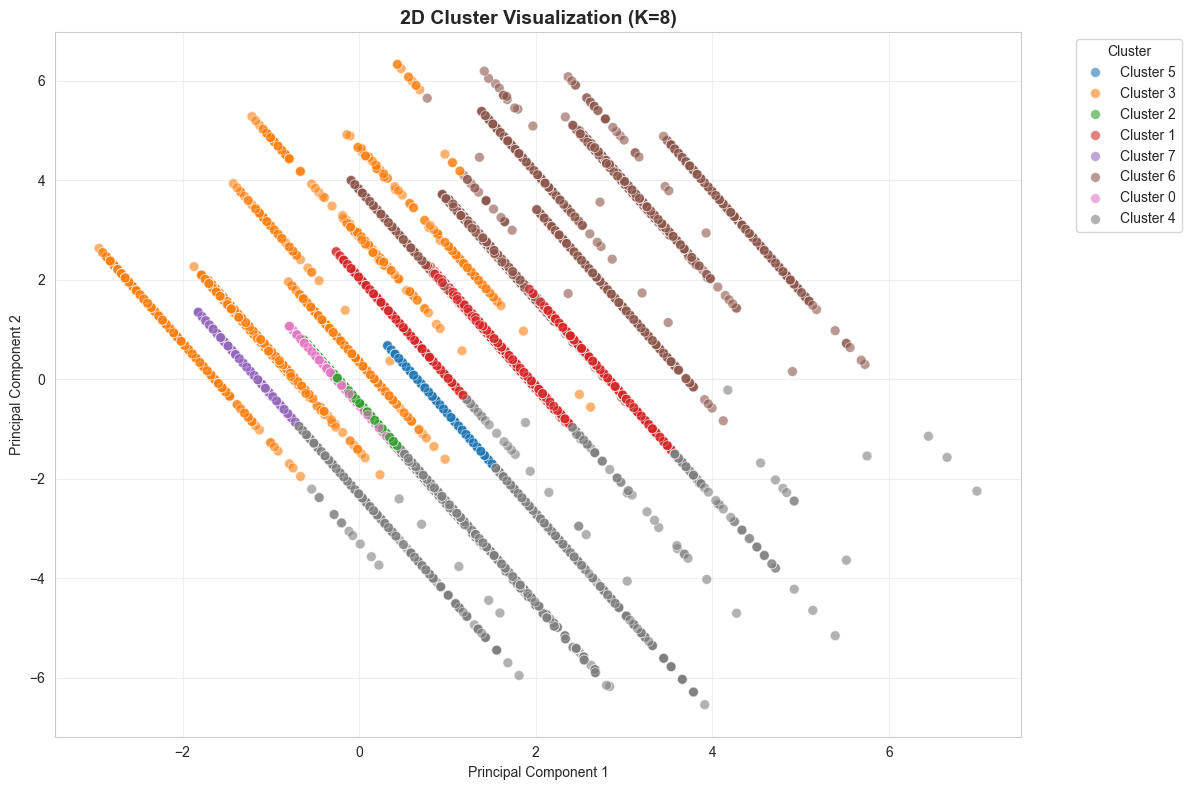

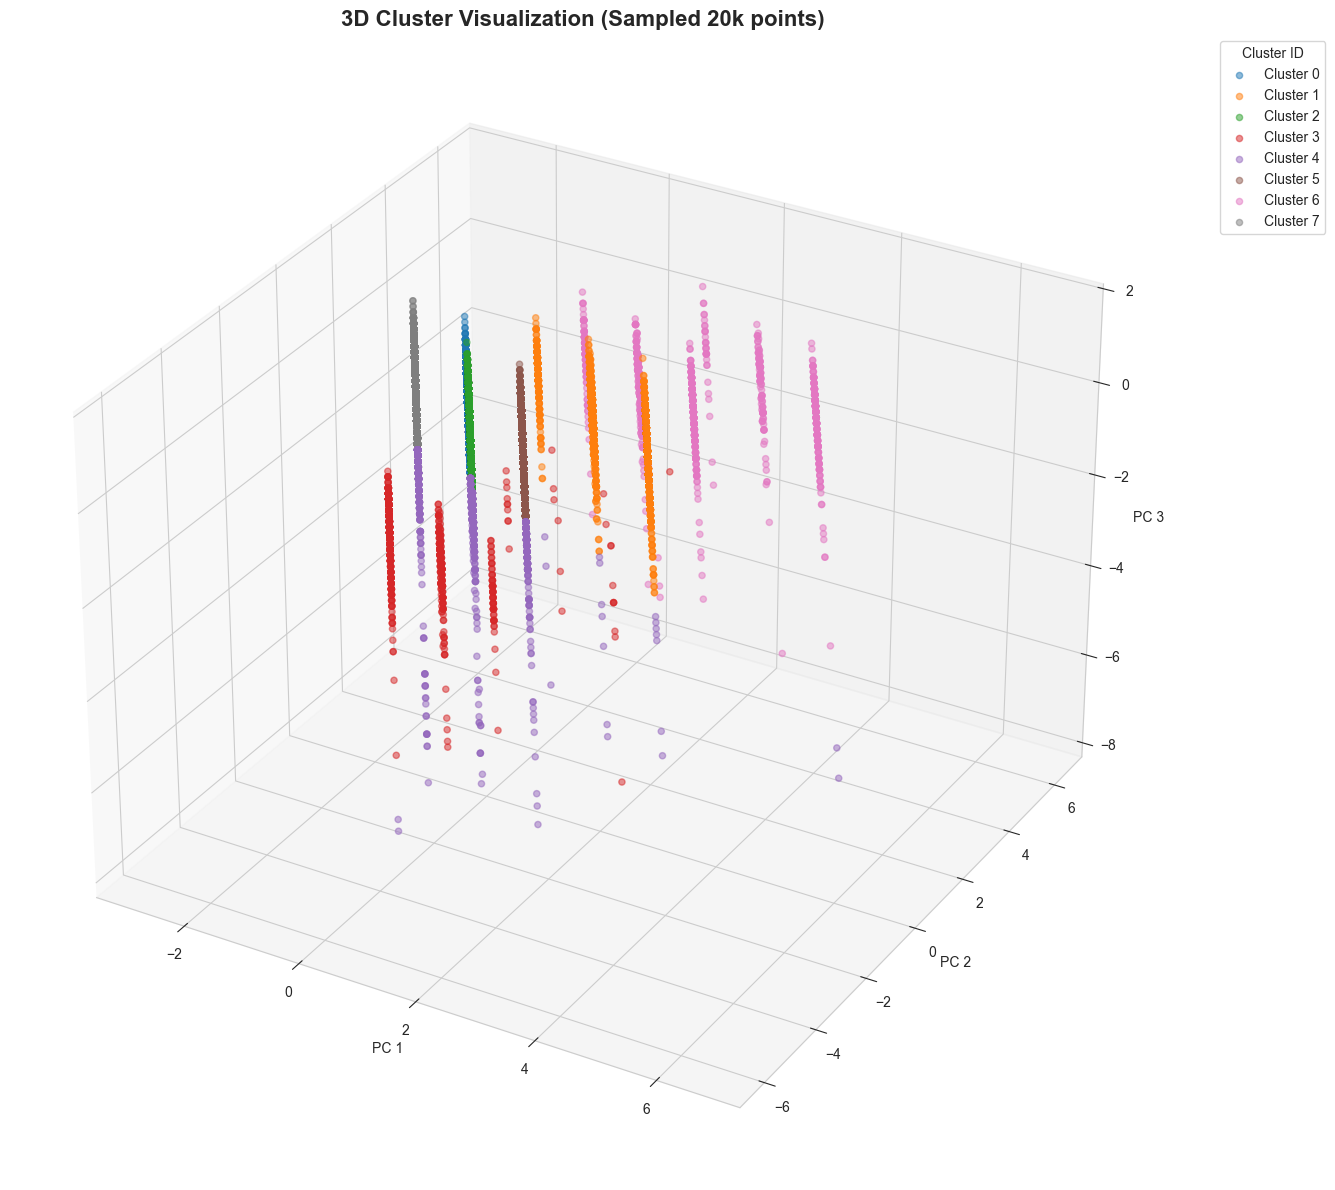


📊 Final Cluster Sizes:
   Cluster 0: 33,023 (14.4%)
   Cluster 1: 19,409 (8.4%)
   Cluster 2: 32,315 (14.1%)
   Cluster 3: 9,220 (4.0%)
   Cluster 4: 10,783 (4.7%)
   Cluster 5: 42,516 (18.5%)
   Cluster 6: 10,171 (4.4%)
   Cluster 7: 72,344 (31.5%)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Setup Data & Features
# Assuming 'X' is your full dataset DataFrame
features_to_use = ['BMI', 'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck']
X_final_raw = X[features_to_use]

print("=" * 60)
print(f"RUNNING FINAL MODEL (K=8) on {len(features_to_use)} Specific Features")
print("=" * 60)

# 2. Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final_raw)

# 3. Fit Final K-Means Model
final_k = 8
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_scaled)

# 4. Dimensionality Reduction (PCA)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# 5. Create Plotting DataFrame
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = labels_final
df_plot['Cluster Label'] = df_plot['Cluster'].apply(lambda x: f'Cluster {x}')

print(f"✅ Model Fitted. Cluster labels assigned to {len(df_plot):,} rows.")

# -----------------------------
# 📊 2D PLOT (PC1 vs PC2) - NO JITTER
# -----------------------------
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Cluster Label', 
    data=df_plot, 
    palette='tab10', 
    alpha=0.6, 
    s=50
)
plt.title(f'2D Cluster Visualization (K={final_k})', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 🧊 3D PLOT (PC1 vs PC2 vs PC3) - NO JITTER
# -----------------------------
# Plotting a sample for 3D performance, but using exact coordinates
df_3d_sample = df_plot.sample(n=min(20000, len(df_plot)), random_state=42)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Get discrete colormap
cmap = plt.get_cmap('tab10')

for cluster_id in sorted(df_3d_sample['Cluster'].unique()):
    subset = df_3d_sample[df_3d_sample['Cluster'] == cluster_id]
    
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'], 
        color=cmap(cluster_id), 
        label=f'Cluster {cluster_id}', 
        s=20, 
        alpha=0.5
    )

ax.set_title(f'3D Cluster Visualization (Sampled 20k points)', fontsize=16, fontweight='bold')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# -----------------------------
# 📈 CLUSTER DISTRIBUTION
# -----------------------------
counts = df_plot['Cluster'].value_counts().sort_index()
print("\n📊 Final Cluster Sizes:")
for i, count in counts.items():
    print(f"   Cluster {i}: {count:,} ({count/len(df_plot)*100:.1f}%)")

(continue with new - profiling those clusters)

In [27]:
import pandas as pd

# 1. Define the features we want to analyze (Clustering features + Descriptors)
# We analyze the original unscaled values
analyze_cols = ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 
                'PhysActivity', 'BMI', 'Age']

# 2. Group by Cluster and calculate averages
profile_table = df_clustered.groupby('Cluster')[analyze_cols].mean()

# 3. Add Cluster Size and Percentage
cluster_counts = df_clustered['Cluster'].value_counts()
profile_table.insert(0, 'Size', cluster_counts)
profile_table.insert(1, '% of Total', (cluster_counts / len(df_clustered)) * 100)

# 4. Add Diabetes Prevalence (The Outcome Variable)
# We calculate the % of people in each cluster who actually have Diabetes (Class 2.0)
diabetes_dist = pd.crosstab(df_clustered['Cluster'], df_clustered['Diabetes_012'], normalize='index')
profile_table['Diabetes %'] = diabetes_dist[2.0] * 100

# 5. Decode "Age" into meaningful ranges
# Function to map the Age code to a string
def decode_age(age_val):
    age_map = {
        1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44', 6: '45-49',
        7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'
    }
    return age_map.get(round(age_val), "Unknown")

profile_table['Avg Age Group'] = profile_table['Age'].apply(decode_age)

# 6. Assign "Risk Labels" based on Diabetes Prevalence
def get_risk_label(pct):
    if pct > 25: return "🔴 HIGH"
    elif pct > 15: return "🟠 MODERATE"
    else: return "🟢 LOW"

profile_table['Risk Level'] = profile_table['Diabetes %'].apply(get_risk_label)

# 7. FORMATTING THE TABLE (Cleanup)
# Convert binary features (0-1) to Percentages (0-100) for readability
binary_cols = ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'PhysActivity']
for col in binary_cols:
    profile_table[col] = profile_table[col] * 100

# Reorder columns for logical flow
final_order = [
    'Risk Level', 'Size', '% of Total', 'Diabetes %', 
    'Avg Age Group', 'BMI', 
    'HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 'PhysActivity'
]
profile_table = profile_table[final_order]

# Rename columns for the final report
profile_table.columns = [
    'Risk Level', 'Count', '% Population', 'Diabetes Prevalence', 
    'Avg Age', 'Avg BMI', 
    'High BP (%)', 'High Chol (%)', 'Heart Disease (%)', 'Stroke (%)', 'Active (%)'
]

print("=" * 80)
print("📊 COMPLETE CLUSTER PROFILE (K=8)")
print("=" * 80)
print(profile_table.round(1).to_string())

# Optional: Export to CSV for your report
# profile_table.round(2).to_csv('cluster_profiles_k8.csv')

📊 COMPLETE CLUSTER PROFILE (K=8)
        Risk Level  Count  % Population  Diabetes Prevalence Avg Age  Avg BMI  High BP (%)  High Chol (%)  Heart Disease (%)  Stroke (%)  Active (%)
Cluster                                                                                                                                             
0            🟢 LOW  33023          14.4                 10.0   55-59     27.4          0.0          100.0                0.0         0.0        77.5
1           🔴 HIGH  19409           8.4                 31.5   65-69     29.3         73.9           70.0              100.0         0.0        65.5
2            🟢 LOW  32315          14.1                 14.7   60-64     28.5        100.0            0.0                0.0         0.0        73.4
3            🟢 LOW   9220           4.0                  2.4   50-54     27.2         18.1           20.8                2.5         1.0        74.5
4           🔴 HIGH  10783           4.7                 28.1   50-54     

explanation for report :
it gives best siluette score and gives best separation between different features. provides opportunity to analyse those features one at the time 
analyse all low risk vs all high risk. fin all similarities and differences

(previous)visualisation of k means !!!!!!!!

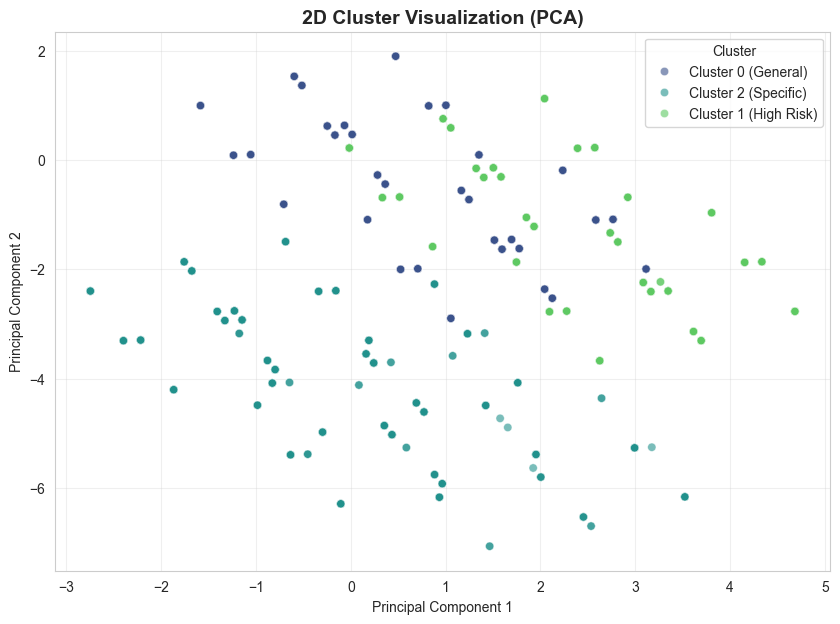

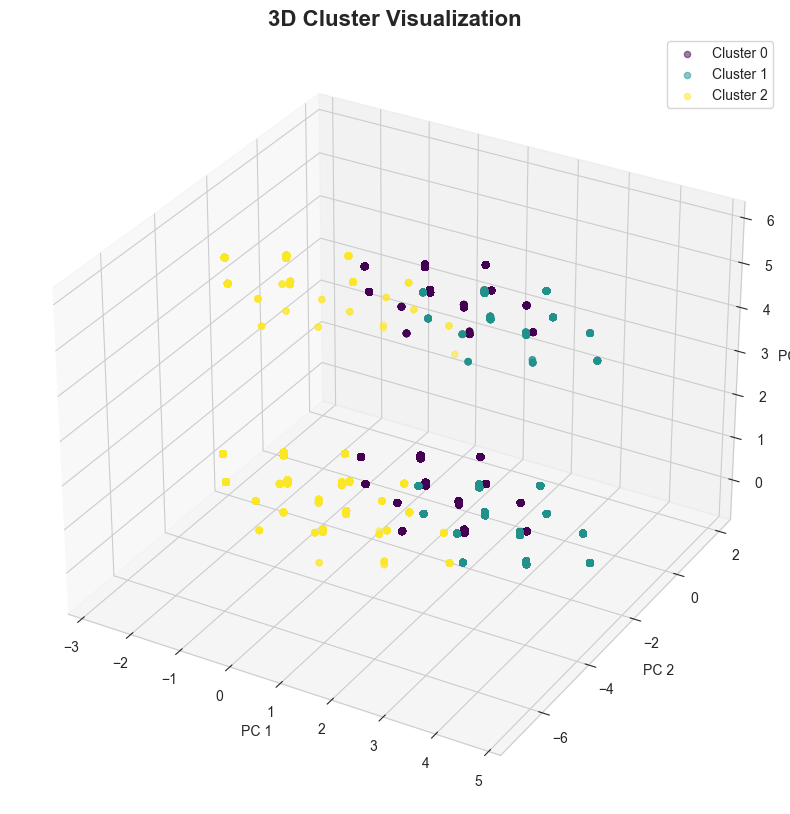

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# 1. Reduce dimensions to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_final) # Use the scaled data (X_final) for valid PCA

# Create a DataFrame for plotting
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = labels_final
# Map cluster numbers to meaningful names (optional, based on your interpretation)
cluster_map = {0: 'Cluster 0 (General)', 1: 'Cluster 1 (High Risk)', 2: 'Cluster 2 (Specific)'}
df_plot['Cluster Label'] = df_plot['Cluster'].map(cluster_map)

# -----------------------------
# 📊 2D PLOT (PC1 vs PC2)
# -----------------------------
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster Label', data=df_plot, palette='viridis', alpha=0.6)
plt.title('2D Cluster Visualization (PCA)', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------
# 🧊 3D PLOT (PC1 vs PC2 vs PC3)
# -----------------------------
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Color mapping
colors = {0: '#440154', 1: '#21918c', 2: '#fde725'} # Viridis colors

for cluster in sorted(df_plot['Cluster'].unique()):
    subset = df_plot[df_plot['Cluster'] == cluster]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], 
               c=colors[cluster], label=f'Cluster {cluster}', s=20, alpha=0.5)

ax.set_title('3D Cluster Visualization', fontsize=16, fontweight='bold')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend()
plt.show()

## 📊 Step 11: Cluster Profiling

In [12]:
df_clustered = df.copy()
df_clustered['Cluster'] = labels_final

print("=" * 60)
print("CLUSTER PROFILES (All Original Features)")
print("=" * 60)

# Profile on all features for interpretation
cluster_profiles = df_clustered.groupby('Cluster')[X.columns].mean()

print("\n📊 Key Health Indicators:")
key_features = ['HighBP', 'HighChol', 'BMI', 'Age', 'PhysActivity', 'HeartDiseaseorAttack']
print(cluster_profiles[key_features].round(2))

# Diabetes distribution
print("\n📊 Diabetes Distribution Within Clusters (%):")
diabetes_dist = pd.crosstab(df_clustered['Cluster'], df_clustered['Diabetes_012'], normalize='index') * 100
print(diabetes_dist.round(1))

# Cluster interpretation
print("\n💡 Cluster Interpretation:")
for cluster_id in sorted(cluster_counts.keys()):
    profile = cluster_profiles.loc[cluster_id]
    diabetes_pct = diabetes_dist.loc[cluster_id, 2.0]
    
    print(f"\n🔵 Cluster {cluster_id}:")
    print(f"   Size: {cluster_counts[cluster_id]:,} ({cluster_counts[cluster_id]/len(labels_final)*100:.1f}%)")
    print(f"   Diabetes prevalence: {diabetes_pct:.1f}%")
    print(f"   HighBP: {profile['HighBP']*100:.0f}%")
    print(f"   HighChol: {profile['HighChol']*100:.0f}%")
    print(f"   BMI: {profile['BMI']:.1f}")
    print(f"   Age: {profile['Age']:.1f}")
    
    # Risk label
    if diabetes_pct > 25:
        risk = "HIGH RISK"
    elif diabetes_pct > 15:
        risk = "MODERATE RISK"
    else:
        risk = "LOW RISK"
    print(f"   → {risk} cluster")

CLUSTER PROFILES (All Original Features)

📊 Key Health Indicators:
         HighBP  HighChol    BMI    Age  PhysActivity  HeartDiseaseorAttack
Cluster                                                                    
0          0.43      0.42  28.65   7.91          0.74                  0.00
1          0.75      0.70  29.50  10.14          0.64                  1.00
2          0.18      0.21  27.28   6.64          0.74                  0.03

📊 Diabetes Distribution Within Clusters (%):
Diabetes_012   0.0  1.0   2.0
Cluster                      
0             84.3  2.0  13.7
1             63.9  2.8  33.3
2             96.7  0.7   2.6

💡 Cluster Interpretation:

🔵 Cluster 0:
   Size: 197,037 (85.7%)
   Diabetes prevalence: 13.7%
   HighBP: 43%
   HighChol: 42%
   BMI: 28.7
   Age: 7.9
   → LOW RISK cluster

🔵 Cluster 1:
   Size: 23,446 (10.2%)
   Diabetes prevalence: 33.3%
   HighBP: 75%
   HighChol: 70%
   BMI: 29.5
   Age: 10.1
   → HIGH RISK cluster

🔵 Cluster 2:
   Size: 9,298 (4.0

## ✅ Summary

In [13]:
print("=" * 60)
print("CLUSTERING ANALYSIS COMPLETE")
print("=" * 60)

print(f"\n🏆 Best Strategy: {best_strategy_name}")
print(f"📊 Features Used: {best['N_Features']}")
print(f"📈 Silhouette Score: {silhouette_final:.3f}")
print(f"📉 Davies-Bouldin: {davies_bouldin_final:.3f}")

improvement = ((silhouette_final - 0.09) / 0.09) * 100
print(f"\n💡 Improvement over baseline: {improvement:.1f}%")

print("\n✅ Ready for supervised learning (Notebook 05)")

CLUSTERING ANALYSIS COMPLETE

🏆 Best Strategy: HighEffect_Only
📊 Features Used: 7
📈 Silhouette Score: 0.440
📉 Davies-Bouldin: 1.070

💡 Improvement over baseline: 388.4%

✅ Ready for supervised learning (Notebook 05)
